In [1]:
#Load Libraries
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np 
import joblib
import os
import yaml
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import json
from datetime import datetime
import copy
import hashlib

C:\Users\HP\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#PARAMS LOAD
params_dir = 'C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/config/params.yaml'

def load_params(param_dir):
    with open(param_dir, 'r') as file:
        params = yaml.safe_load(file)
        
    return params

params = load_params(params_dir)

params

{'col': ['tanggal',
  'stasiun',
  'pm10',
  'pm25',
  'so2',
  'co',
  'o3',
  'no2',
  'max',
  'critical',
  'categori'],
 'dataset_dir': 'C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/data/',
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'missing_value_co': 11,
 'missing_value_no2': 18,
 'missing_value_o3': 29,
 'missing_value_pm10': {'BAIK': 27, 'TIDAK BAIK': 57},
 'missing_value_pm25': {'BAIK': 38, 'TIDAK BAIK': 84},
 'missing_value_so2': 35,
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co': [-1, 100],
 'range_no2': [-1, 100],
 'range_o3': [-1, 160],
 'range_pm10': [-1, 800],
 'range_pm25': [-1, 400],
 'range_so2': [-1, 500],
 'range_stasi

In [3]:
# Data Definition


tanggal         :
    [datetime]
    [00:00 01/06/2021 - 23:59 31/12/2021]
    waktu saat pengambilan sampel

stasiun         :
    [object]
    ['DKI1 (Bunderan HI)', 'DKI2 (Kelapa Gading)', 'DKI3 (Jagakarsa)', 'DKI4 (Lubang Buaya)', 'DKI5 (Kebon Jeruk) Jakarta Barat']
    lokasi saat pengambilan sampel

pm10            :
    [integer]
    [0 - 800]
    partikel udara yang berukuran lebih kecil dari 10 mikron

pm25            :
    [integer]
    [0 - 400]
    partikel udara yang berukuran lebih kecil dari 2.5 mikron

so2             :
    [integer]
    [0 - 500]
    sulfur dioksida

co              :
    [integer]
    [0 - 100]
    karbon monoksida

o3              :
    [integer]
    [0 - 140]
    ozone

no2             :
    [integer]
    [0 - 100]
    nitrogen dioksida

max             :
    [integer]
    [0 - 800]
    nilai paling besar diantara pm10, pm25, so2, co, o3, dan no2

critical        :
    [object]
    [PM10, PM25, SO2, CO, O3, dan NO2]
    nama kolom untuk nilai max

categori        :
    [object]
    [BAIK, SEDANG, TIDAK SEHAT]
    kategori untuk data pengukuran udara

location        : tidak termasuk karena ada data yang nama kolomnya tidak standar
    

SyntaxError: invalid syntax (<ipython-input-3-ae6629d1c528>, line 4)

In [4]:
#DATA COLLECTION

# fungsi untuk membaca nama file, memuat file, dan menggabungkan dataset
def read_dataset(dataset_dir, col):
    dataset = pd.DataFrame()

    for i in tqdm(os.listdir(dataset_dir)):
        print(i)
        data_i = pd.read_csv(dataset_dir + i)
        data_i.rename(columns = {'location':'stasiun'},inplace = True)
        data_i.columns = col
        print(data_i.columns)
        dataset = pd.concat([data_i, dataset])
    
    return dataset


# melakukan pembacaan nama file, memuat file, dan menggabungkan dataset
dataset = read_dataset(params["dataset_dir"],params["col"])

# reset index untuk ,mencegah index yang tidak align
dataset.reset_index(inplace = True, drop = True)

print(dataset.shape)


#cleansing critical feature
dataset = dataset.loc[dataset['critical'] != 'BAIK']
dataset = dataset.loc[dataset['critical'] != 'nan']
print(dataset.shape)

#cleansing numerical feature
for i in ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max']:
    dataset[i] = dataset[i].replace("---",-1).astype(int)

    
    

    
print(dataset.shape)

dataset = dataset.dropna(axis=0,subset=['critical'])
    
print(dataset.shape)

# cek perubahan tipe data untuk kolom tanggal
dataset.tanggal = pd.to_datetime(dataset.tanggal)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 257.70it/s]

indeks-standar-pencemar-udara-di-spku-bulan-agustus-tahun-2021.csv
Index(['tanggal', 'stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')
indeks-standar-pencemar-udara-di-spku-bulan-desember-tahun-2021.csv
Index(['tanggal', 'stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')
indeks-standar-pencemar-udara-di-spku-bulan-juli-tahun-2021.csv
Index(['tanggal', 'stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')
indeks-standar-pencemar-udara-di-spku-bulan-juni-tahun-2021.csv
Index(['tanggal', 'stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')
indeks-standar-pencemar-udara-di-spku-bulan-november-tahun-2021.csv
Index(['tanggal', 'stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori'],
      dtype='object')
indeks-st

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   1060 non-null   datetime64[ns]
 1   stasiun   1060 non-null   object        
 2   pm10      1060 non-null   int32         
 3   pm25      1060 non-null   int32         
 4   so2       1060 non-null   int32         
 5   co        1060 non-null   int32         
 6   o3        1060 non-null   int32         
 7   no2       1060 non-null   int32         
 8   max       1060 non-null   int32         
 9   critical  1060 non-null   object        
 10  categori  1060 non-null   object        
dtypes: datetime64[ns](1), int32(7), object(3)
memory usage: 70.4+ KB


In [6]:
#Data Defense
def check_data(input_data, params):
    # check data types
    assert input_data.select_dtypes("datetime").columns.to_list() == params["datetime_columns"], "an error occurs in datetime column(s)."
    assert input_data.select_dtypes("object").columns.to_list() == params["object_columns"], "an error occurs in object column(s)."
    assert input_data.select_dtypes("int").columns.to_list() == params["int32_columns"], "an error occurs in int32 column(s)."

    # check range of data
    assert set(input_data.stasiun).issubset(set(params["range_stasiun"])), "an error occurs in stasiun range."
    assert input_data.pm10.between(params["range_pm10"][0], params["range_pm10"][1]).sum() == len(input_data), "an error occurs in pm10 range."
    assert input_data.pm25.between(params["range_pm25"][0], params["range_pm25"][1]).sum() == len(input_data), "an error occurs in pm25 range."
    assert input_data.so2.between(params["range_so2"][0], params["range_so2"][1]).sum() == len(input_data), "an error occurs in so2 range."
    assert input_data.co.between(params["range_co"][0], params["range_co"][1]).sum() == len(input_data), "an error occurs in co range."
    assert input_data.o3.between(params["range_o3"][0], params["range_o3"][1]).sum() == len(input_data), "an error occurs in o3 range."
    assert input_data.no2.between(params["range_no2"][0], params["range_no2"][1]).sum() == len(input_data), "an error occurs in no2 range."
    

# jika tidak ada error berarti data sudah sesuai dengan desain kita
check_data(dataset, params)

# simpan dataset yang telah digabungkan
joblib.dump(dataset, 'C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/dataset.pkl')



['C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/dataset.pkl']

In [7]:
#Data Splitting
# pisahkan data x dan y (x adalah fitur, y adalah label)
x = dataset[params["predictors"]].copy()
y = dataset.categori.copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)
# x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42, stratify = y_test)

In [8]:
print(x.info())
print(y.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060 entries, 0 to 1069
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stasiun  1060 non-null   object
 1   pm10     1060 non-null   int32 
 2   pm25     1060 non-null   int32 
 3   so2      1060 non-null   int32 
 4   co       1060 non-null   int32 
 5   o3       1060 non-null   int32 
 6   no2      1060 non-null   int32 
dtypes: int32(6), object(1)
memory usage: 41.4+ KB
None
SEDANG         791
TIDAK SEHAT    207
BAIK            62
Name: categori, dtype: int64


In [9]:
joblib.dump(x_train, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_train.pkl")
joblib.dump(y_train, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_train.pkl")
# joblib.dump(x_valid, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_valid.pkl")
# joblib.dump(y_valid, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_valid.pkl")
joblib.dump(x_test, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_test.pkl")
joblib.dump(y_test, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_test.pkl")

['C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_test.pkl']

In [10]:

datatrain = pd.concat([x_train, y_train], axis = 1)

datatrain.reset_index(inplace = True, drop = True)
datatrain

,stasiun,pm10,pm25,so2,co,o3,no2,categori
0,DKI3 (Jagakarsa),57,84,45,12,22,15,SEDANG
1,DKI3 (Jagakarsa),54,81,45,4,19,13,SEDANG
2,DKI4 (Lubang Buaya),60,110,42,19,18,23,TIDAK SEHAT
3,DKI3 (Jagakarsa),52,71,52,17,22,19,SEDANG
4,DKI3 (Jagakarsa),60,84,47,7,23,18,SEDANG
...,...,...,...,...,...,...,...,...
843,DKI5 (Kebon Jeruk) Jakarta Barat,46,75,27,8,27,12,SEDANG
844,DKI5 (Kebon Jeruk) Jakarta Barat,45,64,-1,4,24,12,SEDANG
845,DKI5 (Kebon Jeruk) Jakarta Barat,54,-1,23,13,25,22,SEDANG
846,DKI3 (Jagakarsa),54,76,50,8,32,14,SEDANG


In [11]:
# Exploratory Data Analysis [EDA]


#Check Missing Value
print(f'jumlah missing value {datatrain.isnull().sum().sum()}')

#Check if we need to do imputation based on class
datatrain_baik = datatrain[datatrain.categori == "BAIK"].copy()
datatrain_tidak_baik = datatrain[datatrain.categori != "BAIK"].copy()
# kelas 1
print('data baik')
print(datatrain_baik.describe())
# kelas 2
print('data tidak baik')
print(datatrain_tidak_baik.describe())

jumlah missing value 0
data baik
            pm10       pm25        so2         co         o3        no2
count  49.000000  49.000000  49.000000  49.000000  49.000000  49.000000
mean   26.673469  32.591837  27.571429   6.755102  22.612245  10.244898
std     8.954486  15.834980  14.608787   4.140907  11.659789   5.517135
min    -1.000000  -1.000000  -1.000000   2.000000  -1.000000  -1.000000
25%    22.000000  28.000000  14.000000   4.000000  14.000000   6.000000
50%    27.000000  36.000000  31.000000   7.000000  17.000000   9.000000
75%    31.000000  44.000000  40.000000   8.000000  32.000000  13.000000
max    50.000000  50.000000  50.000000  28.000000  48.000000  29.000000
data tidak baik
             pm10        pm25         so2          co          o3         no2
count  799.000000  799.000000  799.000000  799.000000  799.000000  799.000000
mean    56.176471   83.894869   36.324155   11.548185   30.150188   22.197747
std     14.762027   23.295454   15.871075    4.463146   13.434235    

In [12]:
    # pm10      : mean dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas
    # pm25      : mean dari kelas 0 dan 1 terpaut cukup jauh, maka akan menggunakan kelas
    # so2       : mean dari kelas 0 dan 1 tidak terpaut jauh, maka tidak akan menggunakan kelas
    # co        : median dari kelas 0 dan 1 tidak terpaut jauh, maka tidak akan menggunakan kelas
    # o3        : median dari kelas 0 dan 1 tidak terpaut jauh, maka tidak akan menggunakan kelas
    # no2       : median dari kelas 0 dan 1 tidak terpaut jauh, maka tidak akan menggunakan kelas

In [13]:
dataset['categori'].unique()

array(['SEDANG', 'BAIK', 'TIDAK SEHAT'], dtype=object)

Line2D(_child1)


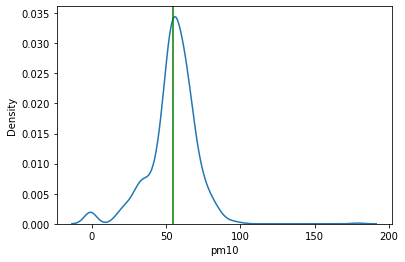

In [14]:
# plot untuk melihat distribusi pm10 jika tidak dibedakan berdasarkan categori
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "pm10")
print(plt.axvline(dataset.pm10.mean(), 0, 1, color = "g"))


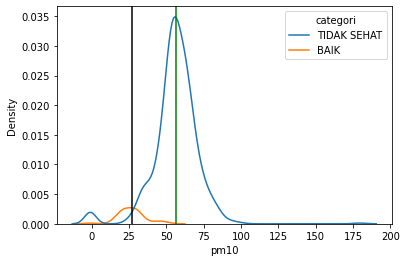

In [15]:

# plot untuk melihat distribusi pm10 jika dibedakan berdasarkan categori
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "pm10", hue = "categori")
plt.axvline(datatrain_tidak_baik.pm10.mean(), 0, 1, color = "g")
plt.axvline(datatrain_baik.pm10.mean(), 0, 1, color = "k")

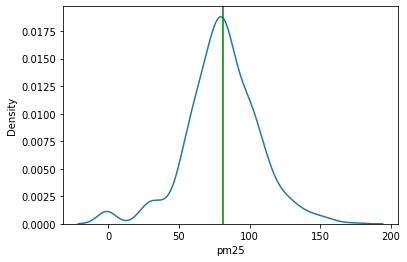

In [16]:

# plot untuk melihat distribusi pm10 jika dibedakan berdasarkan categori
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "pm25")
plt.axvline(datatrain.pm25.mean(), 0, 1, color = "g")

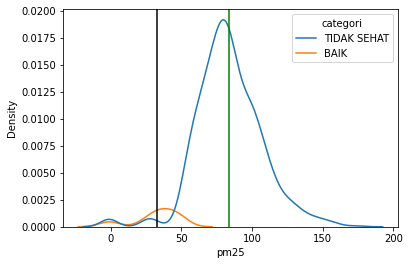

In [17]:
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "pm25", hue = "categori")
plt.axvline(datatrain_tidak_baik.pm25.mean(), 0, 1, color = "g")
plt.axvline(datatrain_baik.pm25.mean(), 0, 1, color = "k")

<function matplotlib.pyplot.show(close=None, block=None)>

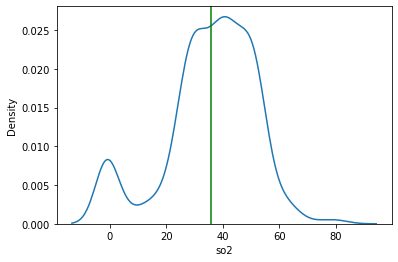

In [18]:

# plot untuk melihat distribusi so2 jika dibedakan berdasarkan categori
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "so2")
plt.axvline(datatrain.so2.mean(), 0, 1, color = "g")
plt.show


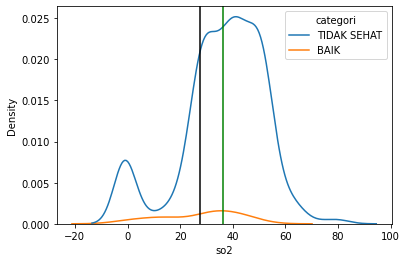

In [19]:

sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "so2", hue = "categori")
plt.axvline(datatrain_tidak_baik.so2.mean(), 0, 1, color = "g")
plt.axvline(datatrain_baik.so2.mean(), 0, 1, color = "k")

<function matplotlib.pyplot.show(close=None, block=None)>

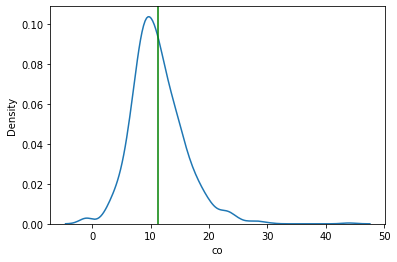

In [20]:

# plot untuk melihat distribusi co jika dibedakan berdasarkan categori
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "co")
plt.axvline(datatrain.co.mean(), 0, 1, color = "g")
plt.show


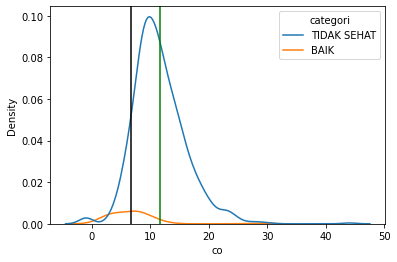

In [21]:

sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "co", hue = "categori")
plt.axvline(datatrain_tidak_baik.co.mean(), 0, 1, color = "g")
plt.axvline(datatrain_baik.co.mean(), 0, 1, color = "k")

<function matplotlib.pyplot.show(close=None, block=None)>

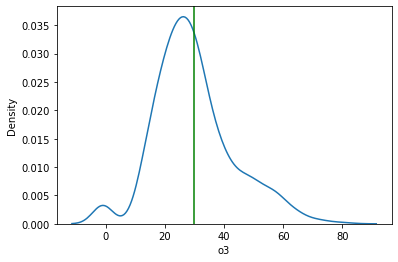

In [22]:

# plot untuk melihat distribusi o3 jika dibedakan berdasarkan categori
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "o3")
plt.axvline(datatrain.o3.mean(), 0, 1, color = "g")
plt.show


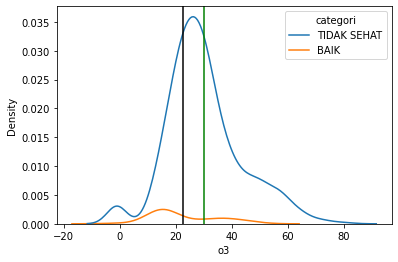

In [23]:

sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "o3", hue = "categori")
plt.axvline(datatrain_tidak_baik.o3.mean(), 0, 1, color = "g")
plt.axvline(datatrain_baik.o3.mean(), 0, 1, color = "k")

<function matplotlib.pyplot.show(close=None, block=None)>

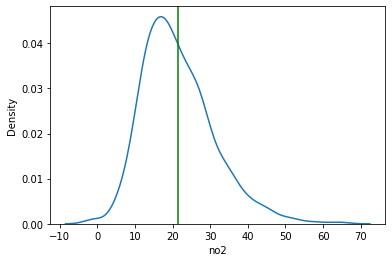

In [24]:

# plot untuk melihat distribusi no2 jika dibedakan berdasarkan categori
sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "no2")
plt.axvline(datatrain.no2.mean(), 0, 1, color = "g")
plt.show


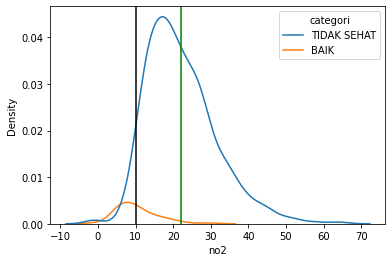

In [25]:

sns.kdeplot(data = datatrain.replace("SEDANG", "TIDAK SEHAT"), x = "no2", hue = "categori")
plt.axvline(datatrain_tidak_baik.no2.mean(), 0, 1, color = "g")
plt.axvline(datatrain_baik.no2.mean(), 0, 1, color = "k")

<AxesSubplot:>

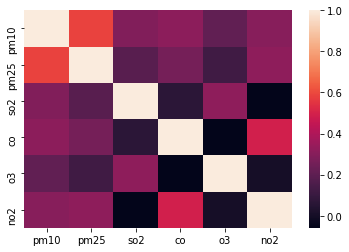

In [26]:
#PEARSON CORELLATION
sns.heatmap(datatrain.corr())

In [27]:
#T-test for predictors betwee categories
# perform t-test untuk 2 variabel
for i in ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2']:
       print(np.where((scs.ttest_ind(
            datatrain_baik[datatrain_baik[i].isnull() != True][i],
            datatrain_tidak_baik[datatrain_tidak_baik[i].isnull() != True][i]
        )[0]<scs.t.ppf(0.05, df = (len(dataset) - 2))) &(scs.ttest_ind(
            datatrain_baik[datatrain_baik[i].isnull() != True][i],
            datatrain_tidak_baik[datatrain_tidak_baik[i].isnull() != True][i]
        )[1]<0.05),"mean antara kelas 0 dan kelas 1 untuk " + i +"statistically significant","mean antara kelas 0 dan kelas 1 untuk " + i +"statistically not significant"))
        

mean antara kelas 0 dan kelas 1 untuk pm10statistically significant
mean antara kelas 0 dan kelas 1 untuk pm25statistically significant
mean antara kelas 0 dan kelas 1 untuk so2statistically significant
mean antara kelas 0 dan kelas 1 untuk costatistically significant
mean antara kelas 0 dan kelas 1 untuk o3statistically significant
mean antara kelas 0 dan kelas 1 untuk no2statistically significant


SEDANG         633
TIDAK SEHAT    166
BAIK            49
Name: categori, dtype: int64


<AxesSubplot:xlabel='categori', ylabel='Count'>

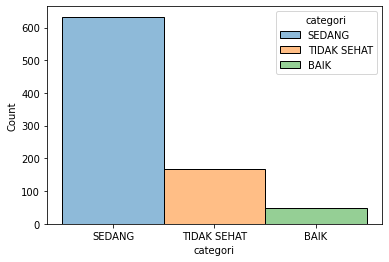

In [28]:
#Check Imbalance Label
print(datatrain.categori.value_counts())

sns.histplot(data = datatrain, x = "categori", hue = "categori")

In [29]:
#PROCESS AND FEATURE ENGINEERING

In [29]:
dataset = pd.concat([x_train, y_train], axis = 1)

# valid_set = pd.concat([x_valid, y_valid], axis = 1)

test_set = pd.concat([x_test, y_test], axis = 1)

In [30]:
# Join Categories

def params_updater(key, value, params, params_dir):
    params = params.copy()
    params[key] = value

    with open(params_dir, "w") as file:
        yaml.dump(params, file)
    
    params = load_params(params_dir)

    return params

def join_cat(set_data, params):
    if params["label"] in set_data.columns.to_list():
        set_data = set_data.copy()
        set_data.categori.replace(params["label_categories"][1], params["label_categories"][2], inplace = True)
        set_data.categori.replace(params["label_categories"][2], params["label_categories_new"][1], inplace = True)
        return set_data
    else:
        raise RuntimeError("Kolom label tidak terdeteksi pada set data yang diberikan!")
        
params = params_updater("label", "categori", params, params_dir)
params = params_updater("label_categories", ["BAIK", "SEDANG", "TIDAK SEHAT"], params, params_dir)
params = params_updater("label_categories_new", ["BAIK", "TIDAK BAIK"], params, params_dir)

dataset = join_cat(dataset, params)

# valid_set = join_cat(valid_set, params)

test_set = join_cat(test_set, params)



In [32]:
#Handling Missing Value

def nan_detector(set_data):
    set_data = set_data.copy()
    set_data.replace(-1, np.nan, inplace = True)
    return set_data

dataset = nan_detector(dataset)

# valid_set = nan_detector(valid_set)

test_set = nan_detector(test_set)


#HANDLING PM10 & PM 25

for i in ['pm10','pm25']:
    impute_1 = int(dataset[dataset.categori == "BAIK"][i].mean())
    impute_0 = int(dataset[dataset.categori == "TIDAK BAIK"][i].mean())

    params = params_updater("missing_value_"+i, {"BAIK": impute_1, "TIDAK BAIK": impute_0}, params, params_dir)

    dataset.loc[dataset[(dataset.categori == "BAIK") & (dataset[i].isnull() == True)].index, i] = impute_1
    dataset.loc[dataset[(dataset.categori == "TIDAK BAIK") & (dataset[i].isnull() == True)].index, i] = impute_0

#     valid_set.loc[valid_set[(valid_set.categori == "BAIK") & (valid_set[i].isnull() == True)].index, i] = impute_1
#     valid_set.loc[valid_set[(valid_set.categori == "TIDAK BAIK") & (valid_set[i].isnull() == True)].index, i] = impute_0

    test_set.loc[test_set[(test_set.categori == "BAIK") & (test_set[i].isnull() == True)].index, i] = impute_1
    test_set.loc[test_set[(test_set.categori == "TIDAK BAIK") & (test_set[i].isnull() == True)].index, i] = impute_0

#Handling in SO2, CO, O3, dan NO2

impute_so2 = int(dataset.so2.mean())
impute_co = int(dataset.co.median())
impute_o3 = int(dataset.o3.median())
impute_no2 = int(dataset.no2.median())

impute_values = {"so2" : impute_so2, "co" : impute_co, "o3" : impute_o3, "no2" : impute_no2}
params = params_updater("missing_value_so2", 35, params, params_dir)
params = params_updater("missing_value_co", 11, params, params_dir)
params = params_updater("missing_value_o3", 29, params, params_dir)
params = params_updater("missing_value_no2", 18, params, params_dir)

dataset.fillna(value = impute_values, inplace = True)
# valid_set.fillna(value = impute_values, inplace = True)
test_set.fillna(value = impute_values, inplace = True)


In [33]:
#ENCODING STASIUN FEATURE

ohe_statiun = OneHotEncoder(sparse = False)
ohe_statiun.fit(np.array(params["range_stasiun"]).reshape(-1, 1))

ohe_statiun.categories_

joblib.dump(ohe_statiun, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/model/ohe_stasiun.pkl")

stasiun_features = ohe_statiun.transform(np.array(dataset.stasiun.to_list()).reshape(-1, 1))
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])
stasiun_features.set_index(dataset.index, inplace = True)
dataset = pd.concat([stasiun_features, dataset], axis = 1)
dataset.drop(columns = "stasiun", inplace = True)

# stasiun_features = ohe_statiun.transform(np.array(valid_set.stasiun.to_list()).reshape(-1, 1))
# stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])
# stasiun_features.set_index(valid_set.index, inplace = True)
# valid_set = pd.concat([stasiun_features, valid_set], axis = 1)
# valid_set.drop(columns = "stasiun", inplace = True)

stasiun_features = ohe_statiun.transform(np.array(test_set.stasiun.to_list()).reshape(-1, 1))
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])
stasiun_features.set_index(test_set.index, inplace = True)
test_set = pd.concat([stasiun_features, test_set], axis = 1)
test_set.drop(columns = "stasiun", inplace = True)

<AxesSubplot:xlabel='categori', ylabel='Count'>

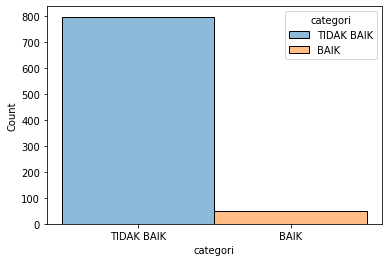

In [39]:
#BALANCING LABEL
sns.histplot(data = dataset, x = "categori", hue = "categori")


<AxesSubplot:xlabel='categori', ylabel='Count'>

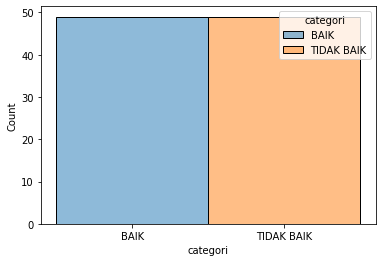

In [40]:

#Undersampling
rus = RandomUnderSampler(random_state = 26)
x_rus, y_rus = rus.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)
dataset_rus = pd.concat([x_rus, y_rus], axis = 1)
sns.histplot(dataset_rus, x = "categori", hue = "categori")

<AxesSubplot:xlabel='categori', ylabel='Count'>

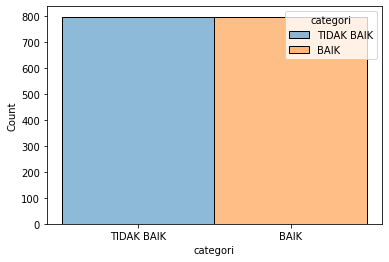

In [41]:
#OVERSAMPLING
ros = RandomOverSampler(random_state = 11)
x_ros, y_ros = ros.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)
dataset_ros = pd.concat([x_ros, y_ros], axis = 1)
sns.histplot(dataset_ros, x = "categori", hue = "categori")

<AxesSubplot:xlabel='categori', ylabel='Count'>

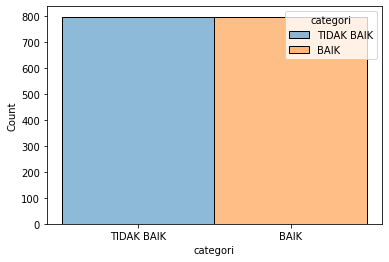

In [42]:
#SMOTE
sm = SMOTE(random_state = 112)
x_sm, y_sm = sm.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)
dataset_sm = pd.concat([x_sm, y_sm], axis = 1)
sns.histplot(dataset_sm, x = "categori", hue = "categori")


In [43]:
#LABEL ENCODING
le_categori = LabelEncoder()
le_categori.fit(params["label_categories_new"])
joblib.dump(le_categori, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/model/le_categori.pkl")
params["label_categories_new"]

y_rus = le_categori.transform(y_rus)
y_ros = le_categori.transform(y_ros)
y_sm = le_categori.transform(y_sm)
# valid_set.categori = le_categori.transform(valid_set.categori)
test_set.categori = le_categori.transform(test_set.categori)

In [44]:
#DUMP FINAL TRAINING TEST AND VALID SET

joblib.dump(x_rus, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_rus.pkl")
joblib.dump(y_rus, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_rus.pkl")

joblib.dump(x_ros, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_ros.pkl")
joblib.dump(y_ros, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_ros.pkl")

joblib.dump(x_sm, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_sm.pkl")
joblib.dump(y_sm, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_sm.pkl")

# joblib.dump(valid_set.drop(columns = "categori"), "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_valid_feng.pkl")
# joblib.dump(valid_set.categori, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_valid_feng.pkl")

joblib.dump(test_set.drop(columns = "categori"), "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_test_feng.pkl")
joblib.dump(test_set.categori, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_test_feng.pkl")

['C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_test_feng.pkl']

In [45]:
#MODELLING

x_rus = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_rus.pkl")
y_rus = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_rus.pkl")

x_ros = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_ros.pkl")
y_ros = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_ros.pkl")

x_sm = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_sm.pkl")
y_sm = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_sm.pkl")

# x_valid = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_valid_feng.pkl")
# y_valid = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_valid_feng.pkl")

x_test = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/x_test_feng.pkl")
y_test = joblib.load("C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/processed/y_test_feng.pkl")

In [46]:
#Create LOG TEMPLATE
def time_stamp():
    return datetime.now()

def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger


def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

In [94]:
#Training and Evaluation


In [48]:
#CREATE MODEL OBJECT
lgr_baseline = LogisticRegression(solver='liblinear')
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

#Hyperparameter Tuning

dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

knn_enh = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420)

list_of_model["undersampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})


In [49]:
#Training Model
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [50]:
#BASELINE MODEL Undersampling
training_log, list_of_model_rus = train_eval_model(list_of_model["undersampling"],"baseline_model",x_rus,y_rus,"undersampling",x_test,y_test,
"C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/log/training_log.json"
)

list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

#BASELINE MODEL Oversampling
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_ros,
    y_ros,
    "oversampling",
    x_test,y_test,
    "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/log/training_log.json"
)

list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)


#BASELINE MODEL SMOTE
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_sm,
    y_sm,
    "smote",
    x_test,y_test,
    "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/log/training_log.json"
)

list_of_model["smote"] = copy.deepcopy(list_of_model_sm)


# #adding hyperparameter tuning

# training_log, list_of_model_rus_hyp = train_eval_model(
#     [list_of_model["undersampling"][-1]],
#     "hyperparams",
#     x_rus,
#     y_rus,
#     "undersampling",
#     x_valid,
#     y_valid,
#     "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/log/training_log.json"
# )

# training_log, list_of_model_ros_hyp = train_eval_model(
#     [list_of_model["oversampling"][-1]],
#     "hyperparams",
#     x_ros,
#     y_ros,
#     "oversampling",
#     x_valid,
#     y_valid,
#     "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/log/training_log.json"
# )

# training_log, list_of_model_sm_hyp = train_eval_model(
#     [list_of_model["smote"][-1]],
#     "hyperparams",
#     x_sm,
#     y_sm,
#     "smote",
#     x_valid,
#     y_valid,
#     "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/log/training_log.json"
# )

# list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_hyp[0])
# list_of_model["oversampling"][-1] = copy.deepcopy(list_of_model_ros_hyp[0])
# list_of_model["smote"][-1] = copy.deepcopy(list_of_model_sm_hyp[0])

 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00, 27.38it/s]C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.92842105 0.94894737 0.93894737 0.93894737 0.93894737 0.93894737
 0.92842105 0.92842105 0.92842105 0.92842105 0.94894737 0.93894737
 0.93894737 0.93894737 0.93894737 0.92842105 0.92842105 0.92842105
 0.92842105 0.94894737 0.93894737 0.93894737 0.93894737 0.93894737
 0.92842105 0.92842105 0.92842105 0.92842105 0.94894737 0.93894737
 0.93894737 0.93894737 0.93894737 0.92842105 0.92842105 0.92842105
 0.92842105 0.94894737 0.93894737 0.93894737 0.93894737 0.93894737
 0.92842105 0.92842105 0.92842105 0.92842105 0.94894737 0.93894737
 0.93894737 0.93894737 0.93894737 0.92842105 0.92842105 0.92842105
 0.92842105 0.94894737 0.93894737 0.93894737 0.93894737 0.93894737
 0.92842105 0.92842105 0.92842105 0.92842105 0.94894737 0.93894737
 0.93894737 0.93894737 0.93894737 0.92842105 0.92842105 0.92842105
 0.92842105 0.94894737 0.93894737 0.93894737 0.93894737 

[14:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.99248629 0.99248629 0.98998629 0.98998629 0.98873433 0.98123237
 0.97622845 0.97247453 0.96997453 0.99248629 0.99248629 0.98998629
 0.98998629 0.98873433 0.98123237 0.97622845 0.97247453 0.96997453
 0.99248629 0.99248629 0.98998629 0.98998629 0.98873433 0.98123237
 0.97622845 0.97247453 0.96997453 0.99248629 0.99248629 0.98998629
 0.98998629 0.98873433 0.98123237 0.97622845 0.97247453 0.96997453
 0.99248629 0.99248629 0.98998629 0.98998629 0.98873433 0.98123237
 0.97622845 0.97247453 0.96997453 0.99248629 0.99248629 0.98998629
 0.98998629 0.98873433 0.98060541 0.97622845 0.97247453 0.96997453
 0.99248629 0.99248629 0.98998629 0.98998629 0.98873433 0.98060541
 0.97622845 0.97247453 0.96997453 0.99248629 0.99248629 0.98998629
 0.98998629 0.98873433 0.98123237 0.97622845 0.97247453 0.96997453
 0.99248629 0.99248629 0.98998629 0.98998629 0.98873433 

[14:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.99186129 0.99248824 0.98935933 0.98935933 0.98748433 0.98123041
 0.97747845 0.97247257 0.97434953 0.99186129 0.99248824 0.98935933
 0.98935933 0.98748433 0.98123041 0.97747845 0.97247257 0.97434953
 0.99186129 0.99248824 0.98935933 0.98935933 0.98748433 0.98123041
 0.97747845 0.97247257 0.97434953 0.99186129 0.99248824 0.98935933
 0.98935933 0.98748433 0.98123041 0.97747845 0.97247257 0.97434953
 0.99186129 0.99248824 0.98935933 0.98935933 0.98748433 0.98123041
 0.97747845 0.97247257 0.97434953 0.99186129 0.99248824 0.98935933
 0.98935933 0.98748433 0.98123041 0.97747845 0.97247257 0.97434953
 0.99186129 0.99248824 0.98935933 0.98935933 0.98748433 0.98123041
 0.97747845 0.97247257 0.97434953 0.99186129 0.99248824 0.98935933
 0.98935933 0.98748433 0.98123041 0.97747845 0.97247257 0.97434953
 0.99186129 0.99248824 0.98935933 0.98935933 0.98748433 

In [51]:
#BEST PERFORMANCES
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    

    print(best_model_info["model_uid"])

    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:

            
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    
    

In [52]:
training_res = training_log_to_df(training_log)
model = get_best_model(training_res, list_of_model)
joblib.dump(model, "C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/model/model.pkl")

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 998.41it/s]

123831a3173bfe42bb4592991719fd49


['C:/Users/HP/Documents/Jeffri Ivander/Data Science/Pacmann AI academy/Tugas/ML Process/project/jeffri-zt9s_ML-_Process2/model/model.pkl']

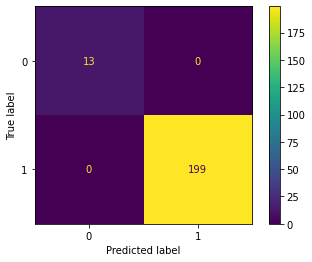

In [54]:
#Confusion Matrix

y_pred = model.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)